In [2]:
""" Imports """
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks, peak_prominences, peak_widths
import sys
import random

In [3]:
""" Pull Data Manually """
ch1data = pd.read_csv("output289ch1_05_08_2023.txt", sep="\t")
ch4data = pd.read_csv("output289ch4_05_08_2023.txt", sep="\t")

ch1data.columns =["Time", "V(compout)-CH1"]
ch4data.columns =["Time", "V(compout)-CH4"]

In [4]:
# fixit = pd.read_csv("Hummingbird_Run/output8000_channel4.txt", sep=' ', names=['current', 'time'])
# fixit = fixit.sort_values(by='time').reset_index(drop=True)
# fixit = fixit[['time', 'current']]
# fixit.to_csv('monte_carlo_input8000ch4_05_08_2023.txt', float_format='%.13f', header=False, index=False, sep=' ')

In [5]:
""" Formatting """

# Create data frame 
ch1 = pd.DataFrame(ch1data)
ch4 = pd.DataFrame(ch4data)

# Check for shorter file and truncate 

# print(f"len ch1: {len(ch1)}\nlen ch4: {len(ch4)}")
# if len(ch1) < len(ch4): 
#     ch1 = ch1.truncate(after=len(ch1)-1) # smallest less 1 bc `after` adds a value
#     ch4 = ch4.truncate(after=len(ch1)-1)
# else: 
#     ch1 = ch1.truncate(after=len(ch4)-1)
#     ch4 = ch4.truncate(after=len(ch4)-1)
# print(f"\nTruncation:\nlen ch1: {len(ch1)}\nlen ch4: {len(ch4)}")

# Naming and floats
ch1t = ch1["Time"].to_numpy()
ch4t = ch4["Time"].to_numpy()
ch1V = ch1["V(compout)-CH1"].to_numpy()
ch4V = ch4["V(compout)-CH4"].to_numpy()

Peak indices
ch1: [   97   375   655   898  1144  1420  1692  1925  2182  2434  2701  2941
  3198  3470  3730  3990  4216  4529  4788  5054  5309  5543  5802  6039
  6286  6578  6862  7090  7327  7603  7833  8066  8370  8622  8883  9123
  9379  9645  9881 10128 10381 10652 10657 10958 11217 11418 11707 11947
 12185 12422 12702 12966 13229 13454 13458 13699 13946 14220 14492 14770
 15003 15286 15542 15767 16034 16301 16581 16812 17132 17137 17357 17653
 17875 18149 18417 18712 19022 19285 19520 19769 20009 20247 20571 20832
 21151 21381 21662 21919 22154 22459 22464 22787 22791 23109 23327 23332
 23566 23806 24045 24301 24561 24849 25159 25413 25651 25894 26220 26505
 26783 27031 27279 27546 27812 28046 28414 28664 28932 29176 29414 29662
 29884 30149 30410 30624 30629 30908 31181 31443 31679 31981 32260 32515
 32776 33012 33251 33499 33756 33992 34305 34598 34866 35187 35451 35684
 35936 36207 36463 36749 37010 37271 37495 37857 38152 38400 38684 38969
 39199 39439 39740 39977 40259 40

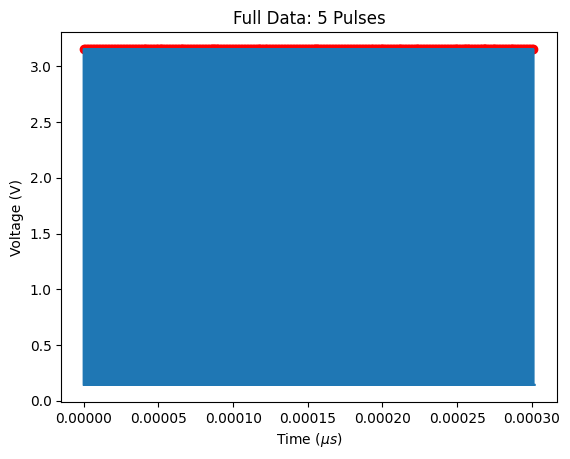

In [6]:
""" 
Find Rising edge (Full dataset): Testing block
    - Threshold voltage: 1.6V 
"""

# View all peaks 
h = 1.6
peakindexCH1, _ = find_peaks(ch1V, height=h)
peakindexCH4, _ = find_peaks(ch4V, height=h)
peaksCH1 = ch1V[peakindexCH1]
peaksCH4 = ch4V[peakindexCH4]

print(f'Peak indices\nch1: {peakindexCH1}\nch4: {peakindexCH4}')

plt.figure(0)
plt.plot(ch1t,ch1V) # nano
plt.scatter(ch1t[peakindexCH1],peaksCH1,  marker='o', color='red')
plt.title("Full Data: 5 Pulses")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Voltage (V)")
plt.show()

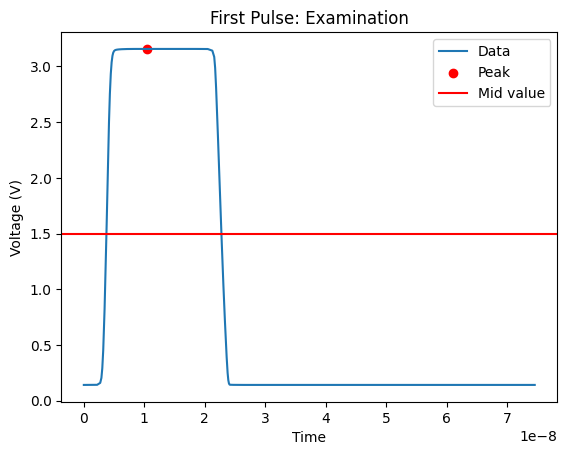

In [125]:
""" 
Find Rising edge (One Peak): Testing block
    - Threshold voltage: 1.6V 
"""

# View one peak
ch1peak = ch1.truncate(after=peakindexCH1[0]+50) # smallest less 1 bc `after` adds a value
ch4peak = ch4.truncate(after=peakindexCH4[0]+50)

# Naming and floats
ch1tpeak = ch1peak["Time"].to_numpy()
ch4tpeak = ch4peak["Time"].to_numpy()
ch1Vpeak = ch1peak["V(compout)-CH1"].to_numpy()
ch4Vpeak = ch4peak["V(compout)-CH4"].to_numpy()

plt.figure(1)
plt.plot(ch1tpeak,ch1Vpeak, label="Data")
plt.scatter(ch1t[peakindexCH1[0]],peaksCH1[0],  marker='o', color='red', label="Peak")
plt.title("First Pulse: Examination")
plt.xlabel("Time")
plt.ylabel("Voltage (V)")
# plt.axvline(x = 6e-9, color = 'b', label = 'axvline - full height')
plt.axhline(y = 1.5, color = 'r', linestyle = '-', label='Mid value')
plt.legend()

In [7]:
""" Interpolation Attempt 1"""

def TOF(ch1V,ch1t,peakindexCH1,peaksCH1,thresh):

    EPS_peak = 0.01
    EPS_valley = min(ch1V) + 0.01
    peakCH1points = np.dstack((ch1t[peakindexCH1[:]], peaksCH1[:]))[0] # [[x1,y1], [x2,y2], ...]

    data = np.dstack((ch1t, ch1V))[0] 
    midpoints = []

    curPeakIDx = 0
    skipToNextPeak = False
    for idx, point in enumerate(data[:-1]):
        if (curPeakIDx >= len(peakCH1points)):
            break
        x,y = point
        peakX, peakY = peakCH1points[curPeakIDx]

        if skipToNextPeak:
            if y < EPS_valley:
                # print(y)
                skipToNextPeak = False
            else:
                continue

        if abs(y - peakY) < EPS_peak:
            midpoints.append((x,y / 2))
            curPeakIDx += 1
            skipToNextPeak = True
        # elif x > peakX:
            # print("passed a peak")
    return data, midpoints

data, midpoints = TOF(ch1V,ch1t,peakindexCH1,peaksCH1,1.5)
data4, midpoints4 = TOF(ch4V,ch4t,peakindexCH4,peaksCH4,1.5)
    


# plt.figure(1)
midpoints = np.array(midpoints)
# print(midpoints[:,0])
# plt.plot(data[:,0], data[:,1])
# plt.scatter(midpoints[:,0], midpoints[:,1], marker='o', color='green')

# plt.figure(2)
midpoints4 = np.array(midpoints4)
# plt.plot(data4[:,0], data4[:,1])
# plt.scatter(midpoints4[:,0], midpoints4[:,1], marker='o', color='green')

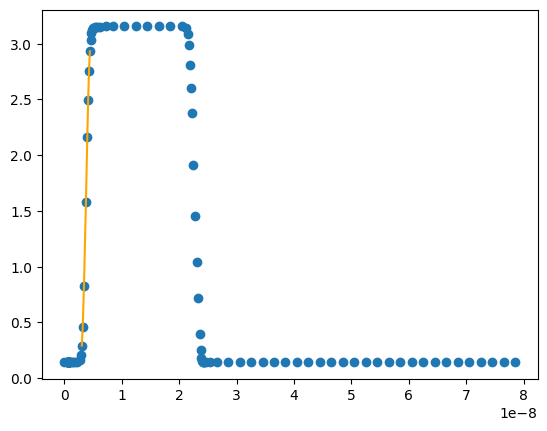

In [8]:
plt.scatter(ch1t[:150],ch1V[:150])
gr = np.gradient(ch1V[:150])
limit = gr >= 0.1 # & gr < 0.5
myvolt = (ch1V[:150])[limit]
mytime = (ch1t[:150])[limit]
np.diff(mytime)
plt.plot(mytime, myvolt, color='orange')
# plt.hist(np.diff(mytime), bins=10)
plt.show()

ch1 length 289 largest time diff 1.00129e-06 zeros 0
[3.70120850e-09 1.00365027e-06 2.00357329e-06 3.00375050e-06
 4.00355584e-06 5.00363012e-06 6.00349570e-06 7.00364581e-06
 8.00385923e-06 9.00346578e-06 1.00036068e-05 1.10035462e-05
 1.20035730e-05 1.30035886e-05 1.40036780e-05 1.50034939e-05
 1.60036614e-05 1.70033315e-05 1.80034796e-05 1.90036361e-05
 2.00034711e-05 2.10036186e-05 2.20035510e-05 2.30036910e-05
 2.40035011e-05 2.50037553e-05 2.60036451e-05 2.70035735e-05
 2.80035103e-05 2.90034967e-05 3.00037992e-05 3.10037244e-05
 3.20035547e-05 3.30035501e-05 3.40034979e-05 3.50038071e-05
 3.60035040e-05 3.70038030e-05 3.80034924e-05 3.90037337e-05
 4.00039121e-05 4.10035848e-05 4.20035495e-05 4.30037356e-05
 4.40036159e-05 4.50038002e-05 4.60039177e-05 4.70037280e-05
 4.80038492e-05 4.90033890e-05 5.00036918e-05 5.10035797e-05
 5.20037230e-05 5.30039928e-05 5.40035215e-05 5.50035075e-05
 5.60035211e-05 5.70035251e-05 5.80038975e-05 5.90034203e-05
 6.00036801e-05 6.10034580e-05 6

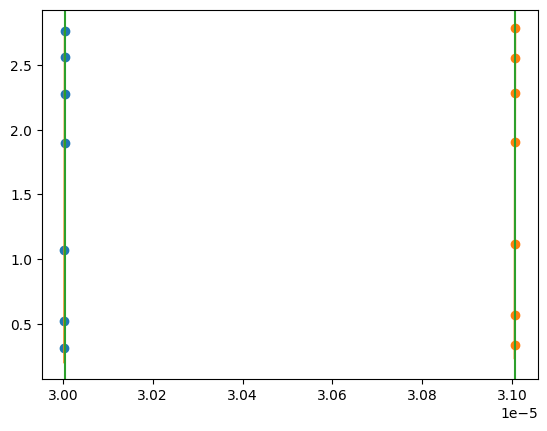

In [15]:
""" Alternate ToF Method Assuming Seperation Width and Known # of Particles"""
def time_at_thresh(tpeak, Vpeak, num, thresh, ch):
    out = []
    grad = np.gradient(Vpeak) # find gradients on all data
    limit = (grad > 0) & (grad >= 0.1) # positive slope bigger than 0.1
    dtime = tpeak[limit]
    dtvoltage = Vpeak[limit]
    tdiff = np.diff(dtime)
    
    condition = tdiff > 1e-7 # check if next point is 100ns away
    # condition2 = tdiff > 1.5e-6 # check if missing points with 1500ns gap
    count = 0
    start_index = 0
    for i in range(len(tdiff)): # for number of particles we expect
        if count > num-1:
            if count==30:
                plt.scatter(dtime[start_index-5:i],dtvoltage[start_index-5:i])
                plt.legend(loc="upper left")
                plt.show()
            return np.array(out)
        if condition[i]: # if condition is true at index i
            
            times = dtime[start_index:i] # take snippet of time from starting index flag to index i
            Voltages = dtvoltage[start_index:i]
            start_index = i+1 # reset flag to next position
            if len(times) < 1 or len(Voltages) < 1: # if no particle here then skip
                continue
            m, b = np.polyfit(times,Voltages, deg=1) # find linear fit
            # if deg=1 returns two params slope m and y-intercept b
            # now use slope and intercept to solve for x value given our mid value y
            # y = mt + b  --> t = (y - b) / m
            out.append( (thresh - b) / m )
            if count==30:
                plt.scatter(times,Voltages)
                plt.plot(times, m*times+b, color='C1', label=f'ch{ch}')
                plt.axvline(out[count], color='C2')
            count +=1 # count particle!
            # if condition2[i]:
            #     count +=1
            
    print("Ch",ch,"counted",count,"particles!")
    if count < num: 
        print(f"Note: Counted less particles than the expected {num}")
        print("Check LTSpice that all particles were simulated.")
    # plt.legend(loc="upper left")
    # plt.show()
    return np.array(out)

def TOF_finalize(tofch1, tofch4, time_limit=10e-9):
    print("ch1 length", len(tofch1), "largest time diff", "%.5e" % max(np.diff(tofch1)), "zeros", (tofch1 == 0.0).sum())
    print(tofch1)
    print("ch4 length", len(tofch4), "largest time diff", "%.5e" % max(np.diff(tofch4)), "zeros", (tofch4 == 0.0).sum())
    print(tofch4)
    out = []
    i = 0; j = 0
    sep = 1e-6
    while (i < len(tofch1)) and (j < len(tofch4)):
        check = tofch1[i] - tofch4[j]
        if abs(check) < time_limit:
            out.append(check)
            i+=1
            j+=1
        elif check > 0:
            # print("be4",tofch1[i],"vs.",tofch4[j])
            j+=1
            # print("now",tofch1[i],"vs.",tofch4[j])
        else: #check < 0
            # print("be4",tofch1[i],"vs.",tofch4[j])
            i+=1
            # print("now",tofch1[i],"vs.",tofch4[j])
    print("finished calculating,", len(out), "particles")
    return np.array(out)


# ch1Tof = TOF_v2(ch1t,ch1V, 1e-6, 5)
num = 289 # number of particles
ch1Tof = time_at_thresh(ch1t,ch1V, num, 1.5, 1)
ch4Tof = time_at_thresh(ch4t,ch4V, num, 1.5, 4)
FinalToF = TOF_finalize(ch1Tof,ch4Tof, num)
print(FinalToF)


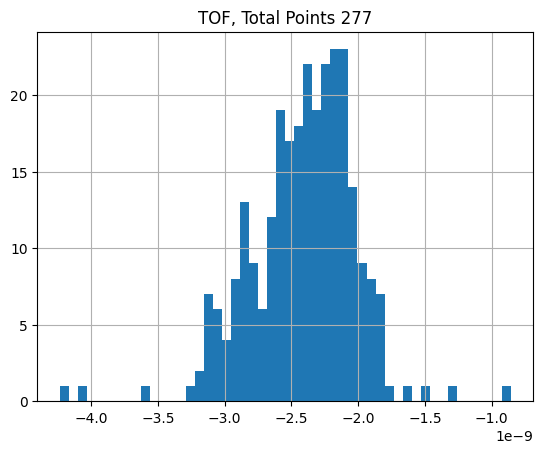

In [19]:
plt.figure(1)
plt.title(f'TOF, Total Points {len(FinalToF)}')
plt.hist(FinalToF, bins=50)
plt.grid()
plt.show()

# of pulses: 1
Voltage List: [1.657259]
# of pulses: 1
Time List: [3.694726814220805e-09]


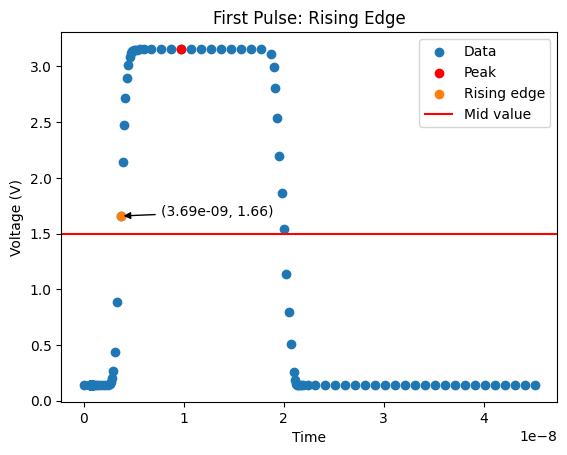

In [7]:
""" Slope checker: One Pulse """

# record 
trise = []
vrise = []
count = 0
eps = 0.45
Vmid = 1.5
pulses = 5

slope = np.diff(ch1Vpeak)/np.diff(ch1tpeak)

for (m,t,v) in zip(slope,ch1tpeak,ch1Vpeak): 
    if (m > 0 ) and (Vmid - eps) <= v <= (Vmid + eps):
        if count <= pulses: 

            trise.append(t)
            vrise.append(v)
            count +=1
        else:
            count +=1
            print('Error, we are beyond the input pulse value.')
            print(f"Pulses: 5\nPulses found: {count}") 


print(f"# of pulses: {len(vrise)}\nVoltage List: {vrise}")
print(f"# of pulses: {len(trise)}\nTime List: {trise}")

plt.figure(1)
plt.scatter(ch1tpeak,ch1Vpeak, label="Data")
plt.scatter(ch1t[peakindexCH1[0]],peaksCH1[0],  marker='o', color='red', label="Peak")
plt.scatter(trise, vrise, label="Rising edge")

point = f"({trise[0]:2.2e}, {vrise[0]:.2f})"
plt.annotate(point, (trise[0],vrise[0]), xytext=(trise[0]+4e-9,vrise[0]), arrowprops={'arrowstyle': '-|>', 'color': 'black'})
plt.axhline(y = 1.5, color = 'r', linestyle = '-', label='Mid value')

plt.title("First Pulse: Rising Edge")
plt.xlabel("Time")
plt.ylabel("Voltage (V)")

plt.legend()

In [21]:
""" 
Rising edge issue: Missing points
- this block can also be used to examine individual peaks
"""

# Select Peak by changing the index: 
#       peakindexCH1[<peak>]
PulseExamined = 3
ch1peak = ch1.truncate(before=peakindexCH1[PulseExamined-1]-20 ,after=peakindexCH1[PulseExamined-1]+50) # smallest less 1 bc `after` adds a value

# Naming and floats
ch1tpeak = ch1peak["Time"].to_numpy()
ch1Vpeak = ch1peak["V(compout)-CH1"].to_numpy()

# Record rising edge values 
trise = []
vrise = []

# Constants
count = 0
eps = 0.5
Vmid = 1.5


slope = np.diff(ch1Vpeak)/np.diff(ch1tpeak)

for (m,t,v) in zip(slope,ch1tpeak,ch1Vpeak):
    if count <= PulseExamined: 
        if (m > 0 ) and (Vmid - eps) <= v <= (Vmid + eps):
            trise.append(t)
            vrise.append(v)
            count +=1
    else:
        print('Error, we are beyond the input pulse value.')
        print(f"Pulses: {PulseExamined}\nPulses found: {count}") 
        break


print(f"# of pulses: {len(vrise)}\nVoltage List: {vrise}")
print(f"# of pulses: {len(trise)}\nTime List: {trise}")

if PulseExamined == 3: 
    print(f"\nVoltage diff of lower point to Mid value: {Vmid-vrise[0]}")
    print(f"Voltage diff of upper point to Mid value: {vrise[1]-Vmid}")


plt.figure(1)
plt.scatter(ch1tpeak,ch1Vpeak, label="Data")
plt.scatter(trise, vrise, label="Rising edge")

plt.axhline(y = Vmid, color = 'r', linestyle = '-', label='Mid value')

plt.title(f"Pulse {PulseExamined}: Rising Edge")
plt.xlabel("Time")
plt.ylabel("Voltage (V)")

plt.legend()

# of pulses: 1
Voltage List: [1.457135]
# of pulses: 1
Time List: [6.309029968704399e-08]

Voltage diff of lower point to Mid value: 0.04286499999999993


IndexError: list index out of range

Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 7
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 8
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 9
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 10
# of pulses: 6
Voltage List: [1.274514, 1.457135, 1.430037, 1.567689, 1.241552, 1.046386]
# of pulses: 6
Time List: [3.354676024648145e-09, 6.309029968704399e-08, 1.003386229627791e-06, 1.067721725422715e-06, 2.003319141767079e-06, 2.062819135557e-06]


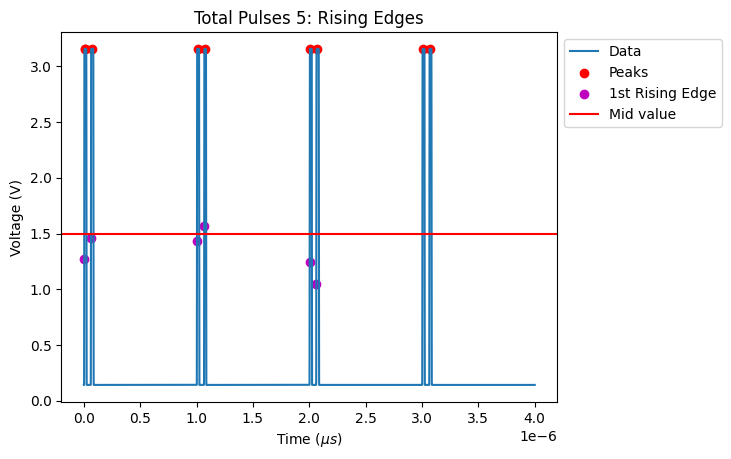

In [22]:
""" Slope checker: N Pulses """
# Input expected number of pulses 
pulses = 5

# record 
trise = []
vrise = []
count = 0
eps = 0.5
Vmid = 1.5


slope = np.diff(ch1V)/np.diff(ch1t)
lasthitT = -1

for (m,t,v) in zip(slope,ch1t,ch1V): 
    if (m > 0 ) and (Vmid - eps) <= v <= (Vmid + eps):
        if ( lasthitT != -1 ) and (np.abs(t - lasthitT) < 4e-9 ):
            continue  
        if count <= pulses: 
            lasthitT = t
            trise.append(t)
            vrise.append(v)
            count +=1
        else:
            count +=1
            print('Error, we are beyond the input pulse value.')
            print(f"Pulses: 5\nPulses found: {count}") 


print(f"# of pulses: {len(vrise)}\nVoltage List: {vrise}")
print(f"# of pulses: {len(trise)}\nTime List: {trise}")

plt.figure(1)
plt.title("Fig 2")
plt.plot(ch1t,ch1V, label="Data")
plt.scatter(ch1t[peakindexCH1[:]],peaksCH1[:],  marker='o', color='red', label ='Peaks')
plt.scatter(trise, vrise, marker='o', color='m', label="1st Rising Edge")
plt.axhline(y = 1.5, color = 'r', linestyle = '-', label='Mid value')


plt.title(f"Total Pulses {pulses}: Rising Edges")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Voltage (V)")

plt.legend(bbox_to_anchor=(1,1))

Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 7
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 8
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 9
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 10
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 11
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 12
# of pulses: 6
Voltage List: [1.274514, 1.457135, 1.430037, 1.567689, 1.241552, 1.983227]
# of pulses: 6
Time List: [3.354676024648145e-09, 6.309029968704399e-08, 1.003386229627791e-06, 1.067721725422715e-06, 2.003319141767079e-06, 2.0036251835065e-06]


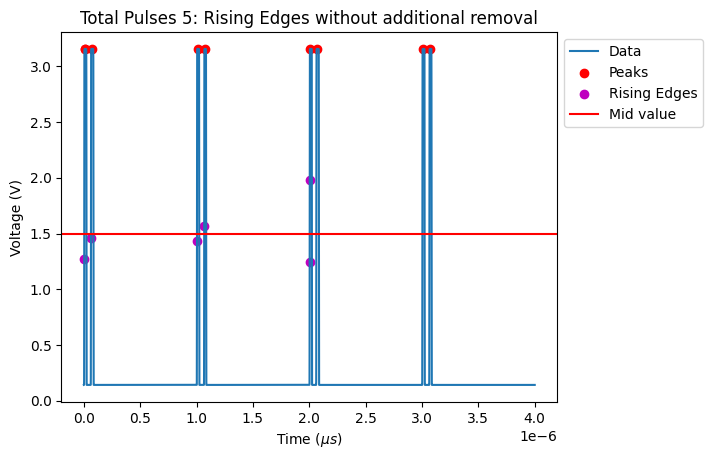

In [23]:
"""
Slope checker: N Pulses 
- without removing extra points
"""
# Input expected number of pulses 
pulses = 5

# record 
trise = []
vrise = []
count = 0
eps = 0.5
Vmid = 1.5


slope = np.diff(ch1V)/np.diff(ch1t)
# lasthitT = -1

for (m,t,v) in zip(slope,ch1t,ch1V): 
    if (m > 0 ) and (Vmid - eps) <= v <= (Vmid + eps):
        # if ( lasthitT != -1 ) and (np.abs(t - lasthitT) < 4e-9 ):
        #     continue  
        if count <= pulses: 
            # lasthitT = t
            trise.append(t)
            vrise.append(v)
            count +=1
        else:
            count +=1
            print('Error, we are beyond the input pulse value.')
            print(f"Pulses: 5\nPulses found: {count}") 


print(f"# of pulses: {len(vrise)}\nVoltage List: {vrise}")
print(f"# of pulses: {len(trise)}\nTime List: {trise}")

plt.figure(1)
plt.title("Fig 2")
plt.plot(ch1t,ch1V, label="Data")
plt.scatter(ch1t[peakindexCH1[:]],peaksCH1[:],  marker='o', color='red', label ='Peaks')
plt.scatter(trise, vrise, marker='o', color='m', label="Rising Edges")
plt.axhline(y = 1.5, color = 'r', linestyle = '-', label='Mid value')


plt.title(f"Total Pulses {pulses}: Rising Edges without additional removal")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Voltage (V)")

plt.legend(bbox_to_anchor=(1,1))

In [24]:
"""
Run both Channels and Plot TOF 
- this is loosly created and should not be used in .py file 
"""

def riseTime(cht, chv, num_pulse,eps=0.5,Vmid=1.5): 
    # record 
    trise = []
    vrise = []
    count = 0
    # eps = 0.5
    # Vmid = 1.5


    slope = np.diff(chv)/np.diff(cht)
    lasthitT = -1

    for (m,t,v) in zip(slope,cht,chv): 
        if (m > 0 ) and (Vmid - eps) <= v <= (Vmid + eps):
            if ( lasthitT != -1 ) and (np.abs(t - lasthitT) < 4e-9 ):
                continue  
            if count <= pulses: 
                lasthitT = t
                trise.append(t)
                vrise.append(v)
                count +=1
            else:
                count +=1
                print('Error, we are beyond the input pulse value.')
                print(f"Pulses: 5\nPulses found: {count}") 


    # print(f"# of pulses: {len(vrise)}\nVoltage List: {vrise}")
    # print(f"# of pulses: {len(trise)}\nTime List: {trise}")

    return np.array(trise)

# Pull Data
def pullData(ch1data,ch4data):
    # Create data frame 
    ch1 = pd.DataFrame(ch1data)
    ch4 = pd.DataFrame(ch4data)

    # Check for shorter file and truncate 

    # print(f"len ch1: {len(ch1)}\nlen ch4: {len(ch4)}")
    if len(ch1) < len(ch4): 
        ch1 = ch1.truncate(after=len(ch1)-1) # smallest less 1 bc `after` adds a value
        ch4 = ch4.truncate(after=len(ch1)-1)
    else: 
        ch1 = ch1.truncate(after=len(ch4)-1)
        ch4 = ch4.truncate(after=len(ch4)-1)
    # print(f"\nTruncation:\nlen ch1: {len(ch1)}\nlen ch4: {len(ch4)}")

    # Naming and floats
    ch1t = ch1["Time"].to_numpy()
    ch4t = ch4["Time"].to_numpy()
    ch1V = ch1["V(compout)-CH1"].to_numpy()
    ch4V = ch4["V(compout)-CH4"].to_numpy()

    return ch1t, ch4t, ch1V, ch4V




Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 7
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 8
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 9
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 10
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 7
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 8
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 9
Error, we are beyond the input pulse value.
Pulses: 5
Pulses found: 10


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1.17080628e-09, 1.24139972e-09, 1.31199315e-09, 1.38258659e-09,
        1.45318003e-09, 1.52377346e-09, 1.59436690e-09, 1.66496034e-09,
        1.73555378e-09, 1.80614721e-09, 1.87674065e-09, 1.94733409e-09,
        2.01792752e-09, 2.08852096e-09, 2.15911440e-09, 2.22970783e-09,
        2.30030127e-09, 2.37089471e-09, 2.44148815e-09, 2.51208158e-09,
        2.58267502e-09, 2.65326846e-09, 2.72386189e-09, 2.79445533e-09,
        2.86504877e-09, 2.93564221e-09, 3.00623564e-09, 3.07682908e-09,
        3.14742252e-09, 3.21801595e-09, 3.28860939e-09, 3.35920283e-09,
        3.42979627e-09, 3.50038970e-09, 3.57098314e-09, 3.64157658e-09,
        3.71217001e-09, 3.78276345e-09, 3.85335689e-09, 3.92395032e-09,
        3.99454376e-09, 4.06513720e-09, 4.13573064e-09

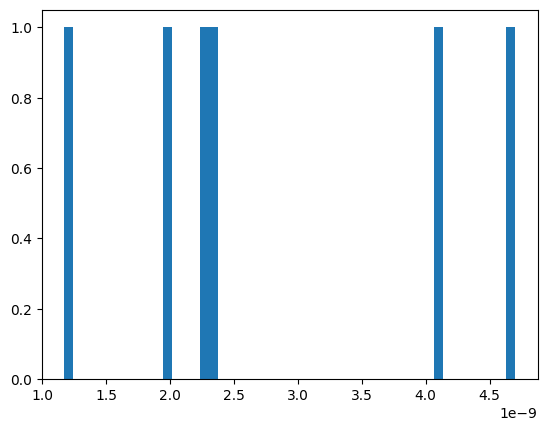

In [26]:
ch1t, ch4t, ch1V, ch4V = pullData(ch1data,ch4data)
tch1 = riseTime(ch1t,ch1V,5)
tch4 = riseTime(ch4t,ch4V,5)

ToF = tch4 - tch1

plt.hist(ToF, bins=50)